In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU') 
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2.2.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.data.shape)
print(housing.target.shape)
print(housing.DESCR)


(20640, 8)
(20640,)
.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which

In [4]:
import pprint
pprint.pprint(housing.data[0:5])
pprint.pprint(housing.target[0:5])

array([[ 8.32520000e+00,  4.10000000e+01,  6.98412698e+00,
         1.02380952e+00,  3.22000000e+02,  2.55555556e+00,
         3.78800000e+01, -1.22230000e+02],
       [ 8.30140000e+00,  2.10000000e+01,  6.23813708e+00,
         9.71880492e-01,  2.40100000e+03,  2.10984183e+00,
         3.78600000e+01, -1.22220000e+02],
       [ 7.25740000e+00,  5.20000000e+01,  8.28813559e+00,
         1.07344633e+00,  4.96000000e+02,  2.80225989e+00,
         3.78500000e+01, -1.22240000e+02],
       [ 5.64310000e+00,  5.20000000e+01,  5.81735160e+00,
         1.07305936e+00,  5.58000000e+02,  2.54794521e+00,
         3.78500000e+01, -1.22250000e+02],
       [ 3.84620000e+00,  5.20000000e+01,  6.28185328e+00,
         1.08108108e+00,  5.65000000e+02,  2.18146718e+00,
         3.78500000e+01, -1.22250000e+02]])
array([4.526, 3.585, 3.521, 3.413, 3.422])


In [5]:
from sklearn.model_selection import train_test_split
x_train_all, x_test, y_train_all, y_test = train_test_split(housing.data, housing.target, random_state=7)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, random_state=11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [6]:
#RandomizedSearchCV
# 1. 转化为sklearn model
# 2. 定义参数集合
# 3. 搜索参数

callbacks = [
        keras.callbacks.EarlyStopping(patience=3, min_delta=1e-3)
]

def build_model(hidden_layers = 1, layer_size = 30, learning_rate = 3e-3):
    model = keras.models.Sequential([
        keras.layers.Dense(layer_size, activation='relu', input_shape=x_train.shape[1:])
    ])
    for _ in range(hidden_layers-1):
        model.add(keras.layers.Dense(layer_size, activation='relu'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss='mse', optimizer=optimizer)
    return model

sklearn_model = keras.wrappers.scikit_learn.KerasRegressor(build_model)
history = sklearn_model.fit(x_train_scaled, y_train, epochs=100,validation_data=(x_valid_scaled, y_valid), callbacks=callbacks)



Epoch 1/100
363/363 [==============================] - 0s 1ms/step - loss: 1.1762 - val_loss: 0.7516
Epoch 2/100
363/363 [==============================] - 0s 1ms/step - loss: 0.6456 - val_loss: 0.6530
Epoch 3/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5684 - val_loss: 0.5836
Epoch 4/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5205 - val_loss: 0.5400
Epoch 5/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4892 - val_loss: 0.5112
Epoch 6/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4679 - val_loss: 0.4877
Epoch 7/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4543 - val_loss: 0.4746
Epoch 8/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4443 - val_loss: 0.4631
Epoch 9/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4359 - val_loss: 0.4529
Epoch 10/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4277 - val_lo

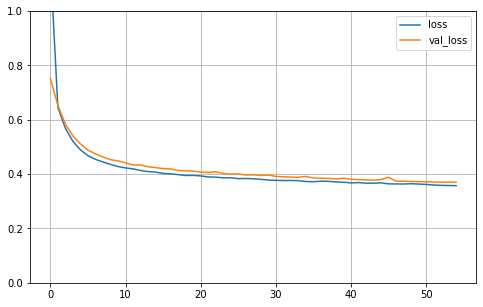

In [7]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()


plot_learning_curves(history)

In [13]:
from scipy.stats import reciprocal
# f(x) = 1/(x*log(b/a)) a<=x<=b

param_distribution = {
    "hidden_layers":[2, 3],
    "layer_size": np.arange(1, 10),
    "learning_rate": reciprocal(1e-3, 1e-2),
}

from sklearn.model_selection import RandomizedSearchCV

random_search_cv = RandomizedSearchCV(sklearn_model, param_distribution, n_iter=10, n_jobs=1)
random_search_cv.fit(x_train_scaled, y_train, epochs=100, validation_data =(x_valid_scaled, y_valid), callbacks=callbacks)

Epoch 1/100
291/291 [==============================] - 0s 1ms/step - loss: 3.9771 - val_loss: 2.3567
Epoch 2/100
291/291 [==============================] - 0s 1ms/step - loss: 1.7854 - val_loss: 1.6208
Epoch 3/100
291/291 [==============================] - 0s 1ms/step - loss: 1.4271 - val_loss: 1.4456
Epoch 4/100
291/291 [==============================] - 0s 1ms/step - loss: 1.3414 - val_loss: 1.3958
Epoch 5/100
291/291 [==============================] - 0s 1ms/step - loss: 1.3152 - val_loss: 1.3753
Epoch 6/100
291/291 [==============================] - 0s 1ms/step - loss: 1.3006 - val_loss: 1.3611
Epoch 7/100
291/291 [==============================] - 0s 1ms/step - loss: 1.2851 - val_loss: 1.3444
Epoch 8/100
291/291 [==============================] - 0s 1ms/step - loss: 1.2630 - val_loss: 1.3210
Epoch 9/100
291/291 [==============================] - 0s 1ms/step - loss: 1.2310 - val_loss: 1.2871
Epoch 10/100
291/291 [==============================] - 0s 2ms/step - loss: 1.1892 - val_lo

RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000018DDC076B08>, as the constructor either does not set or modifies parameter layer_size

In [ ]:
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)
print(random_search_cv.best_estimator_)

In [ ]:
model = random_search_cv.best_estimator_.model
model.evaluate(x_test_scaled, y_test)